In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle



    Only loading the 'en' tokenizer.



## Language modeling

### Data

In [2]:
PATH='data/spooky-author/'

TRN = f'{PATH}train.csv'
TEST = f'{PATH}test.csv'

%ls {PATH}

models/  sample_submission.csv  test.csv  train.csv


In [49]:
trn_df = pd.read_csv(TRN, low_memory=False)
tst_df = pd.read_csv(TEST, low_memory=False)

In [50]:
trn_df.groupby('author')['text'].count()

author
EAP    7900
HPL    5635
MWS    6044
Name: text, dtype: int64

In [51]:
trn_df_eap = trn_df[trn_df['author']=='EAP']
trn_df_hpl = trn_df[trn_df['author']=='HPL']
trn_df_mws = trn_df[trn_df['author']=='MWS']

In [53]:
def save_data(df, file, author):
    file = open(f'{PATH}{author}/{author.lower()}.txt','w')
    trainData =""
    for idx, row in df.iterrows():
        data = row['text']
        if trainData == "":
            trainData = data
        else :
            trainData += " " + data

    file.write(trainData)
    file.close()
    return trainData

In [ ]:
file_train=  

In [29]:
trn_df.text[0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [5]:
' '.join(spacy_tok(trn_df.text[0]))

'This process , however , afforded me no means of ascertaining the dimensions of my dungeon ; as I might make its circuit , and return to the point whence I set out , without being aware of the fact ; so perfectly uniform seemed the wall .'

In [6]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [7]:
bs=4; bptt=70

In [8]:
md = LanguageModelData.from_dataframes(PATH, TEXT, 'text', trn_df, tst_df, tst_df, bs=bs, bptt=bptt)

In [9]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

In [10]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(2124, 25191, 1, 595187)

In [11]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was']

In [12]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['the']

3

In [13]:
next(iter(md.trn_dl))

(Variable containing:
     31     53      8    612
   3075    562     18    741
      2     33    273     12
    153   1276      2   9643
      2  10159     22      3
   1385      2     62   1754
     27      6     80      4
     42     13      2   6780
    304    222      7     65
      4     23     33      3
   7495   3454     10   7346
      3    254      3   2329
   2488     10    983     14
      4    407      4      6
     13      4  11279    130
   4654    434      5     16
     14     22    107     56
     21    627  13918     33
      8    465    181    541
     87      2    212     46
    190     88   7655      8
     55      3    212   1185
   4298     93   1118     32
      2   2023     10    115
      6      2     80    612
    306   5752     47   2056
      7      9    859      7
      3    480    473    136
    258      4      5      3
   2044   3802     19    873
      8      5     55      4
    336    111  13229    165
     83   1422      2   2218
      2   1735      3

In [14]:
md.trn_ds[0].text[:12]

['this',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the']

In [15]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
   31
 3075
    2
  153
    2
 1385
   27
   42
  304
    4
 7495
    3
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

In [16]:
next(iter(md.trn_dl))

(Variable containing:
     31     53      8    612
   3075    562     18    741
      2     33    273     12
    153   1276      2   9643
      2  10159     22      3
   1385      2     62   1754
     27      6     80      4
     42     13      2   6780
    304    222      7     65
      4     23     33      3
   7495   3454     10   7346
      3    254      3   2329
   2488     10    983     14
      4    407      4      6
     13      4  11279    130
   4654    434      5     16
     14     22    107     56
     21    627  13918     33
      8    465    181    541
     87      2    212     46
    190     88   7655      8
     55      3    212   1185
   4298     93   1118     32
      2   2023     10    115
      6      2     80    612
    306   5752     47   2056
      7      9    859      7
      3    480    473    136
    258      4      5      3
   2044   3802     19    873
      8      5     55      4
    336    111  13229    165
     83   1422      2   2218
      2   1735      3

### Train

In [17]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

In [18]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [19]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

In [20]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 85%|████████▌ | 1809/2124 [08:33<01:29,  3.52it/s, loss=25.3]

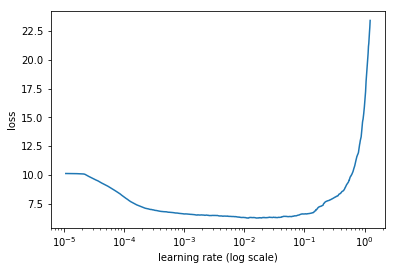

In [21]:
learner.sched.plot()

In [22]:
learner.fit(1e-4, 4, wds=1e-6, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))


  1%|▏         | 29/2124 [00:08<10:15,  3.40it/s, loss=10.1]

  1%|▏         | 29/2124 [00:08<10:31,  3.32it/s, loss=10.1]


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError:

[ 0.       6.62048  6.58543]                                  
[ 1.       6.35803  6.35355]                                  
[ 2.       6.30832  6.3143 ]                                  
[ 3.       6.15483  6.14278]                                  
[ 4.       6.03459  6.04273]                                  
[ 5.       5.97573  6.00109]                                  
[ 6.       5.97683  5.99183]                                  
[ 7.       5.93329  5.92607]                                  
[ 8.       5.86396  5.86616]                                  
[ 9.       5.81053  5.82366]                                  
[ 10.        5.79955   5.79208]                               
[ 11.        5.74794   5.77151]                               
[ 12.        5.73369   5.76351]                               
[ 13.        5.74033   5.75638]                               
[ 14.        5.72786   5.75471]                               



In [23]:
learner.save_encoder('adam1_enc')

In [ ]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=10, cycle_save_name='adam3_10')

In [ ]:
learner.save_encoder('adam3_10_enc')

In [ ]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

In [ ]:
learner.load_cycle('adam3_20', 0)

In [ ]:
learner.save_encoder('adam3_20_enc')

In [ ]:
math.exp(4.165)

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

In [ ]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [ ]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [ ]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

...and let's see if our model can generate a bit more text all by itself!

In [ ]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

### Sentiment

In [ ]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

In [ ]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')

In [ ]:
t = splits[0].examples[0]

In [ ]:
t.label, ' '.join(t.text[:16])

In [ ]:
md2 = TextData.from_splits(PATH, splits, bs)

In [ ]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_20_enc')

In [ ]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [ ]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

In [ ]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

In [ ]:
m3.load_cycle('imdb2', 4)

In [ ]:
accuracy(*m3.predict_with_targs())